In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

In [ ]:
# Function to split data into training, validation, and test sets
def split_data(source_dir, train_dir, val_dir, test_dir, split_size=0.15):
    for class_folder in os.listdir(source_dir):
        class_source_dir = os.path.join(source_dir, class_folder)
        if not os.path.isdir(class_source_dir):
            continue

        print(f'Processing class folder: {class_folder}')
        train_class_dir = os.path.join(train_dir, class_folder)
        val_class_dir = os.path.join(val_dir, class_folder)
        test_class_dir = os.path.join(test_dir, class_folder)

        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        file_list = [f for f in os.listdir(class_source_dir) if os.path.isfile(os.path.join(class_source_dir, f))]
        print(f'Found {len(file_list)} files in {class_folder}')
        if len(file_list) == 0:
            print(f'No files found in {class_folder}, skipping.')
            continue

        train_files, test_files = train_test_split(file_list, test_size=split_size, random_state=42)
        val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

        for file in train_files:
            shutil.copy(os.path.join(class_source_dir, file), os.path.join(train_class_dir, file))
        for file in val_files:
            shutil.copy(os.path.join(class_source_dir, file), os.path.join(val_class_dir, file))
        for file in test_files:
            shutil.copy(os.path.join(class_source_dir, file), os.path.join(test_class_dir, file))

# Define dataset paths
base_dir = '/content/drive/My Drive/Tomato/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Splitting the dataset
split_data(base_dir, train_dir, val_dir, test_dir)

Processing class folder: Tomato___Tomato_mosaic_virus
Found 800 files in Tomato___Tomato_mosaic_virus
Processing class folder: Tomato___Septoria_leaf_spot
Found 800 files in Tomato___Septoria_leaf_spot
Processing class folder: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Found 800 files in Tomato___Tomato_Yellow_Leaf_Curl_Virus
Processing class folder: Tomato___Target_Spot
Found 800 files in Tomato___Target_Spot
Processing class folder: Tomato___Late_blight
Found 800 files in Tomato___Late_blight
Processing class folder: Tomato___Bacterial_spot
Found 800 files in Tomato___Bacterial_spot
Processing class folder: Tomato___Spider_mites Two-spotted_spider_mite
Found 801 files in Tomato___Spider_mites Two-spotted_spider_mite
Processing class folder: Tomato___Early_blight
Found 807 files in Tomato___Early_blight
Processing class folder: Tomato___healthy
Found 800 files in Tomato___healthy
Processing class folder: Tomato___Leaf_Mold
Found 800 files in Tomato___Leaf_Mold


In [ ]:
# base_dir = '/content/drive/My Drive/Tomato/'
# train_dir = os.path.join(base_dir, 'train')
# val_dir = os.path.join(base_dir, 'val')
# test_dir = os.path.join(base_dir, 'test')

In [ ]:
# Image Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Batch size
batch_size = 32

# Generate batches of data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Number of classes
num_classes = len(os.listdir(train_dir))
print(f"Number of classes: {num_classes}")

Found 6805 images belonging to 10 classes.
Found 601 images belonging to 10 classes.
Found 602 images belonging to 10 classes.
Number of classes: 10


In [ ]:
# Feature Extraction Model using VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

base_model.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 26778

In [ ]:
epochs = 40

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/40
212/212 [==============================] - 89s 412ms/step - loss: 1.7195 - accuracy: 0.4093 - val_loss: 1.1621 - val_accuracy: 0.6684
Epoch 2/40
212/212 [==============================] - 86s 406ms/step - loss: 1.2540 - accuracy: 0.5748 - val_loss: 1.0077 - val_accuracy: 0.6667
Epoch 3/40
212/212 [==============================] - 87s 408ms/step - loss: 1.1130 - accuracy: 0.6237 - val_loss: 0.8401 - val_accuracy: 0.7222
Epoch 4/40
212/212 [==============================] - 86s 404ms/step - loss: 0.9981 - accuracy: 0.6616 - val_loss: 0.7946 - val_accuracy: 0.7344
Epoch 5/40
212/212 [==============================] - 86s 404ms/step - loss: 0.9492 - accuracy: 0.6834 - val_loss: 0.7582 - val_accuracy: 0.7500
Epoch 6/40
212/212 [==============================] - 85s 402ms/step - loss: 0.9087 - accuracy: 0.6818 - val_loss: 0.7521 - val_accuracy: 0.7378
Epoch 7/40
212/212 [==============================] - 85s 398ms/step - loss: 0.8827 - accuracy: 0.6972 - val_loss: 0.6613 - val_ac

In [ ]:
# model.save('/content/drive/My Drive/Tomato.keras')
# print("Model saved successfully")

Model saved successfully


In [ ]:
# Load the trained model
model = load_model('/content/drive/My Drive/Tomato.keras')
print("Model loaded successfully")

Model loaded successfully


18/18 [==============================] - 5s 257ms/step - loss: 0.5326 - accuracy: 0.8021
Test accuracy: 0.8020833134651184


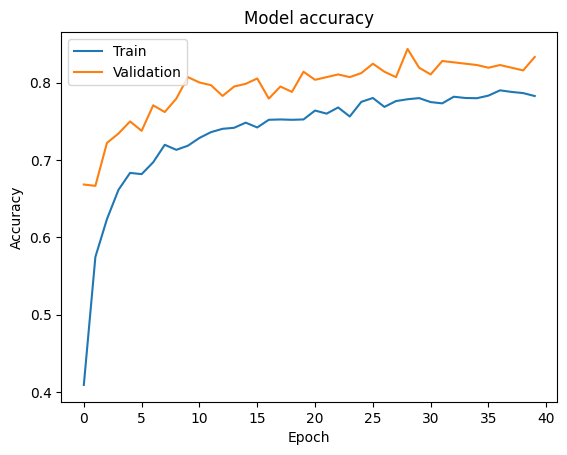

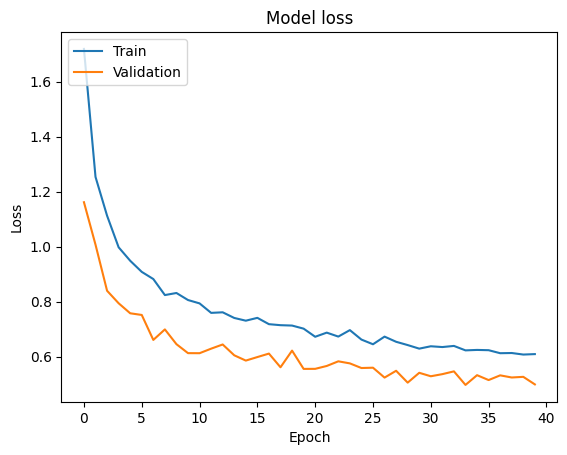

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Class Labels: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


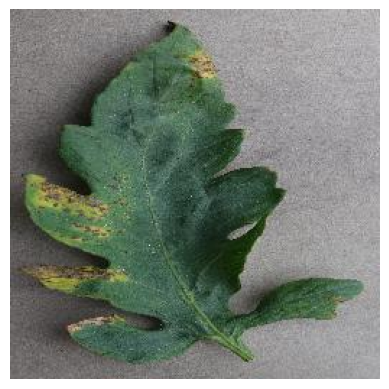

1/1 [==============================] - 0s 194ms/step
Predicted Class: Tomato___Bacterial_spot
Predicted Class Probability: 81.92 %
Actual Class: Tomato   Bacterial spot 

Prediction Array: [[8.1922328e-01 1.7440325e-01 3.1046561e-04 4.9762923e-04 4.3186503e-03
  1.4647240e-07 4.4733893e-06 1.2420614e-03 4.2200185e-08 4.2552301e-10]]
Predicted Class Index: 0
Image Path: /content/drive/My Drive/Tomato/test/Tomato___Bacterial_spot/image (30).JPG


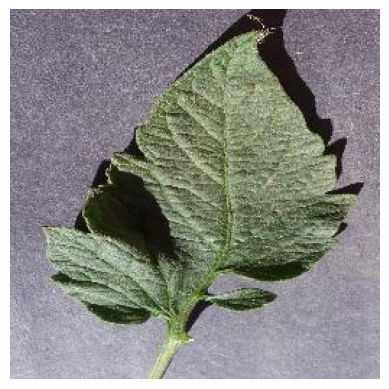

1/1 [==============================] - 0s 53ms/step
Predicted Class: Tomato___healthy
Predicted Class Probability: 56.32 %
Actual Class: Tomato   healthy 

Prediction Array: [[1.1204190e-06 1.3607493e-02 8.1149468e-05 2.8767090e-04 4.2415134e-04
  9.4829082e-02 3.2756487e-01 3.6763904e-06 8.7082790e-06 5.6319201e-01]]
Predicted Class Index: 9
Image Path: /content/drive/My Drive/Tomato/test/Tomato___healthy/image (66).JPG


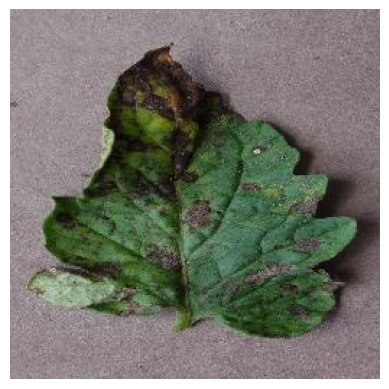

1/1 [==============================] - 0s 53ms/step
Predicted Class: Tomato___Early_blight
Predicted Class Probability: 52.81 %
Actual Class: Tomato   Early blight 

Prediction Array: [[4.4128049e-02 5.2813679e-01 2.5837570e-02 8.5243650e-02 1.0825759e-01
  1.0141711e-02 5.2106854e-02 1.1227318e-01 3.3856113e-02 1.8510053e-05]]
Predicted Class Index: 1
Image Path: /content/drive/My Drive/Tomato/test/Tomato___Early_blight/image (96).JPG


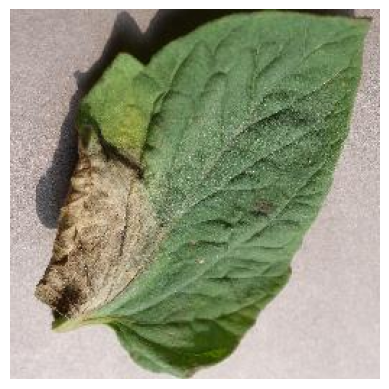

1/1 [==============================] - 0s 53ms/step
Predicted Class: Tomato___Late_blight
Predicted Class Probability: 45.01 %
Actual Class: Tomato   Late blight 

Prediction Array: [[3.70160537e-03 1.41030461e-01 4.50051844e-01 2.68055618e-01
  7.17416480e-02 1.07339965e-02 4.77119014e-02 2.75087659e-04
  6.67796889e-03 1.99976457e-05]]
Predicted Class Index: 2
Image Path: /content/drive/My Drive/Tomato/test/Tomato___Late_blight/image (181).JPG


In [ ]:
!pip install matplotlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Import the matplotlib.image module

def predict_image(model, img_path, class_labels):
    # Extract actual class from image path
    actual_class = os.path.basename(os.path.dirname(img_path)).replace('_', ' ')

    # Load and display the image
    img = mpimg.imread(img_path) # Use mpimg to read the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image for prediction
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    # Display prediction result
    predicted_class_label = class_labels[predicted_class_index]
    predicted_class_probability = np.max(prediction)

    print('Predicted Class:', predicted_class_label)
    print('Predicted Class Probability:', round(predicted_class_probability * 100, 2), '%')
    print('Actual Class:', actual_class, '\n')
    print('Prediction Array:', prediction)
    print('Predicted Class Index:', predicted_class_index)
    print('Image Path:', img_path)

# Automatically define class labels from directories
def get_class_labels(base_dir):
    return sorted(os.listdir(base_dir))

# Define dataset paths
base_dir = '/content/drive/My Drive/Tomato/test'

# Get class labels
class_labels = get_class_labels(base_dir)
print(f"Class Labels: {class_labels}")

# Example usage
image_paths = [
    '/content/drive/My Drive/Tomato/test/Tomato___Bacterial_spot/image (30).JPG',
    '/content/drive/My Drive/Tomato/test/Tomato___healthy/image (66).JPG',
    '/content/drive/My Drive/Tomato/test/Tomato___Early_blight/image (96).JPG',
    '/content/drive/My Drive/Tomato/test/Tomato___Late_blight/image (181).JPG',
]

for image_path in image_paths:
    predict_image(model, image_path, class_labels)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


19/19 - 5s - loss: 0.5181 - accuracy: 0.8073 - 5s/epoch - 275ms/step
Test accuracy: 80.73%


19/19 [==============================] - 5s 264ms/step


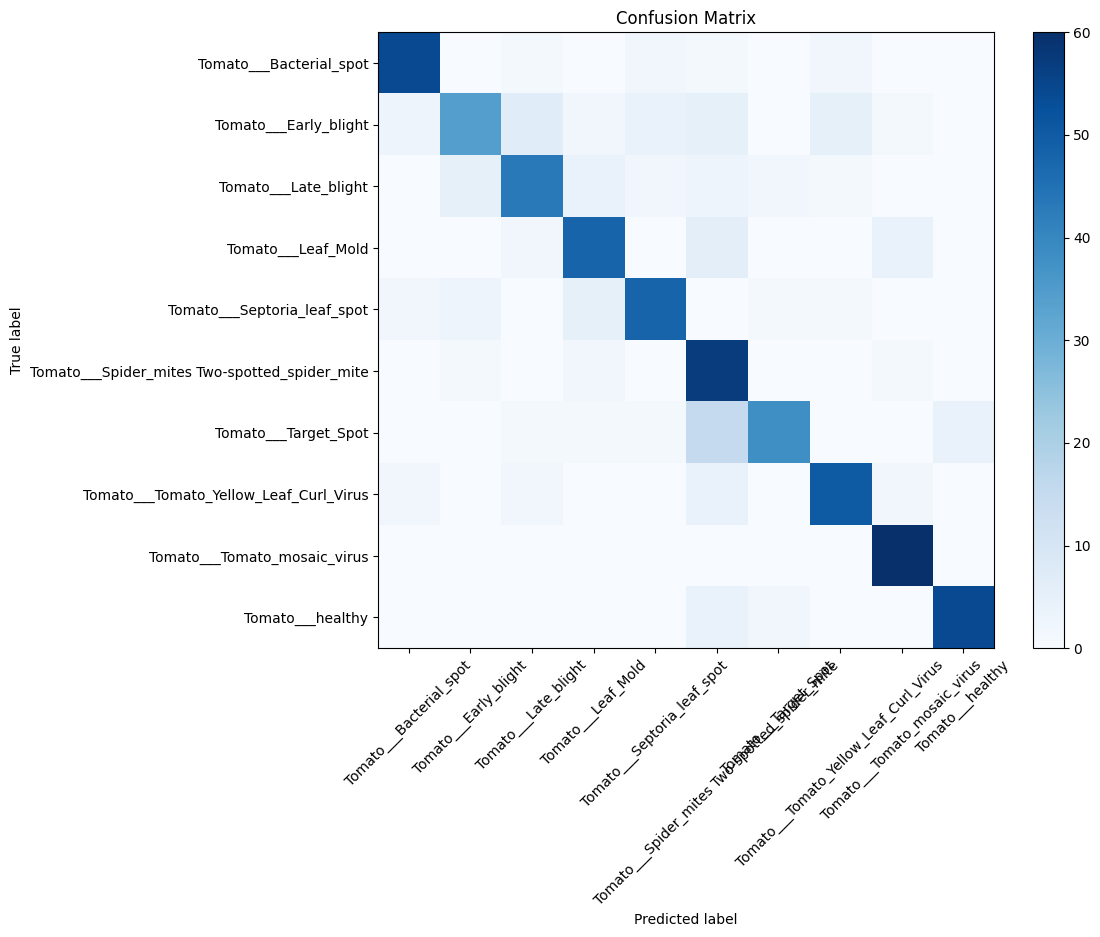

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.89      0.90      0.89        60
                        Tomato___Early_blight       0.79      0.56      0.65        61
                         Tomato___Late_blight       0.77      0.72      0.74        60
                           Tomato___Leaf_Mold       0.77      0.80      0.79        60
                  Tomato___Septoria_leaf_spot       0.84      0.80      0.82        60
Tomato___Spider_mites Two-spotted_spider_mite       0.60      0.93      0.73        61
                         Tomato___Target_Spot       0.88      0.63      0.74        60
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.85      0.83      0.84        60
                 Tomato___Tomato_mosaic_virus       0.88      1.00      0.94        60
                             Tomato___healthy       0.93      0.90      0.92        60

                                     accu

In [ ]:
# Predict on test data
Y_pred = model.predict(test_generator, test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Plot confusion matrix
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))